In [1]:
# 1) Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [14]:
# Start by loading large file. Fill NaN values with 0. data/GSE82221 GPL10558_DiffExpr_Results
# Results in format:
"""
Gene Name, Sample 1 Expression, Sample 2 Expression, Sample 3 Expression, ...
ACC1, 0.534, -0.123, 3.23, ...
"""
data = pd.read_excel("./differential_expression_remove.xlsx").fillna(0).set_index("Unnamed: 0")
data

,GSM260887,GSM260890,GSM260892,GSM260895,GSM260898,GSM260901,GSM260904,GSM260907,GSM260910,GSM260915,...,GSM2159874_GSM2186713,GSM2159875_GSM2186714,GSM2159876_GSM2186715,GSM2159877_GSM2186716,GSM2159878_GSM2186717,GSM2159879_GSM2186718,GSM2159880_GSM2186719,GSM2159881_GSM2186720,GSM2159882_GSM2186721,GSM2159883_GSM2186722
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
AAMP,7.987898,8.146919,7.872645,7.597145,7.869418,7.444805,8.061699,7.710792,8.071035,7.879941,...,7.706938,6.988278,7.735954,6.546169,6.381689,6.501416,6.448938,7.624701,6.814338,7.460934
AAR2,8.200976,8.173634,8.092444,8.232831,8.162719,8.381002,8.054371,8.047274,8.136662,8.129697,...,9.265841,8.674259,9.007166,8.954978,8.511553,8.557573,8.656798,8.830969,8.607525,9.414040
AARS,9.245106,9.191260,8.986071,8.918300,9.207463,9.268225,9.199175,9.253299,9.036789,9.088280,...,10.414229,10.730855,10.750850,10.874624,10.770068,9.892971,10.443322,10.225672,10.087484,10.358513
AASDHPPT,7.520883,6.788238,6.575260,7.036747,7.508357,7.777682,8.008363,7.840830,6.934142,7.570956,...,8.514694,8.001638,8.384378,9.119604,8.370917,8.211381,8.209006,8.180443,8.462781,8.721967
AATF,8.703046,8.915998,8.274914,8.792234,8.887310,8.809920,8.405534,8.165832,8.665352,8.768472,...,8.646712,8.836878,8.937474,8.409900,8.654601,8.622416,9.108593,8.943129,8.857860,8.728813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN32,7.164279,7.165870,7.246966,7.115276,6.924431,7.053697,6.918531,6.969792,7.182219,7.075128,...,8.936343,8.595110,8.542057,8.930000,8.044748,6.907201,8.534103,8.306572,8.378163,8.841689
ZSWIM8,6.506561,6.879131,7.336054,6.974795,5.767546,5.764456,6.070139,5.830443,6.533614,6.444665,...,8.885271,9.064544,8.282370,9.125560,9.027318,8.699951,9.460827,9.210849,8.658267,7.929616
ZXDC,7.895829,7.627829,7.018347,7.375847,8.238326,8.458064,7.630709,7.715188,7.934763,7.740201,...,6.579478,6.903806,6.704035,6.123917,6.645395,6.257242,6.710593,6.748697,6.597415,6.092526


In [97]:
# Use metadata to get which samples are healthy and not healthy.
metadata = pd.read_csv(open("metadata.tsv", "r"), delimiter="\t").set_index("Sample")

train_input, train_output = np.zeros((len(data.columns), len(data.index))), np.zeros((len(data.columns), 2))
one_hot_output = np.zeros(len(data.columns))

# Graph this info
metadata_info = []

p_values = []

# Now iterate through each column of our data, and place it into final_data.
options = list(set(metadata["Condition"]))
for index, sample in enumerate(data.columns):
    # A specific sample will have gene expression values, and then whether they're sick or not.
    # Put into input gene expression values...
    train_input[index] = (data[sample].to_numpy())
    # And put into output whether this person is sick or not (look up user in metadata)
    categorical = np.zeros(len(options))
    categorical[options.index(metadata.loc[sample]["Condition"])] = 1
    metadata_info.append(metadata.loc[sample]["Tissue"])
    
    train_output[index] = categorical
    one_hot_output[index] = options.index(metadata.loc[sample]["Condition"])

train_input = stats.zscore(train_input)

In [98]:
tissue_types = set(metadata_info)
tissue_counts = {t: 0 for t in tissue_types}

for i in metadata_info:
    tissue_counts[i] += 1

tissue_counts

{'Peripheral blood': 768, 'Whole blood': 387, 'Skin': 14}

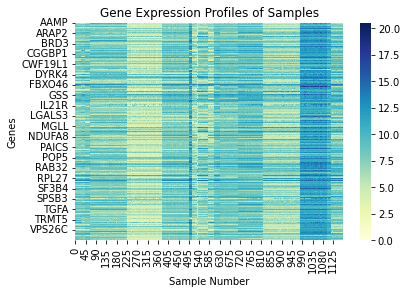

In [114]:
# Observe output and its shape
# For heatmap, order training data by healthiness and sickness

data_rem_names = data.rename(columns = { col: i for i, col in enumerate(data.columns) })
data_rem_names.index.rename("Genes", inplace=True)
plot = sns.heatmap(data_rem_names, cmap="YlGnBu")
plot.set(title= "Gene Expression Profiles of Samples", xlabel="Sample Number")
plot.get_figure().savefig("gene_expression.png")

In [160]:
# Start by creating dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_input[50:], train_output[50:])).shuffle(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((train_input[:50], train_output[:50])).batch(32).cache().prefetch(tf.data.AUTOTUNE)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, input_shape=(train_input.shape[1],)),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax') # [sick probability, healthy probability]
])

# Create model + compile
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "mse"])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 10)                49120     
                                                                 
 dense_68 (Dense)            (None, 20)                220       
                                                                 
 dense_69 (Dense)            (None, 20)                420       
                                                                 
 dense_70 (Dense)            (None, 2)                 42        
                                                                 
Total params: 49,802
Trainable params: 49,802
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(train_input, train_output, epochs = 100, validation_data=test_dataset)

Epoch 1/100
37/37 [==============================] - 0s 7ms/step - loss: 0.7851 - accuracy: 0.6707 - mse: 0.2220 - val_loss: 0.6526 - val_accuracy: 0.6600 - val_mse: 0.2301
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 0.4960 - accuracy: 0.7648 - mse: 0.1581 - val_loss: 0.5597 - val_accuracy: 0.6400 - val_mse: 0.1929
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 0.3830 - accuracy: 0.8306 - mse: 0.1167 - val_loss: 0.4269 - val_accuracy: 0.7800 - val_mse: 0.1410
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 0.3587 - accuracy: 0.8606 - mse: 0.1077 - val_loss: 0.4603 - val_accuracy: 0.7400 - val_mse: 0.1530
Epoch 5/100
37/37 [==============================] - 0s 3ms/step - loss: 0.2713 - accuracy: 0.8811 - mse: 0.0831 - val_loss: 0.3498 - val_accuracy: 0.8400 - val_mse: 0.1128
Epoch 6/100
37/37 [==============================] - 0s 3ms/step - loss: 0.2529 - accuracy: 0.8914 - mse: 0.0762 - val_loss: 0.4089 - v

In [60]:
model.predict(train_input)

array([[9.9960119e-01, 3.9885307e-04],
       [9.9859685e-01, 1.4030909e-03],
       [9.9666923e-01, 3.3307625e-03],
       ...,
       [2.0394926e-09, 1.0000000e+00],
       [2.0841672e-07, 9.9999976e-01],
       [4.0397888e-19, 1.0000000e+00]], dtype=float32)

<AxesSubplot:>

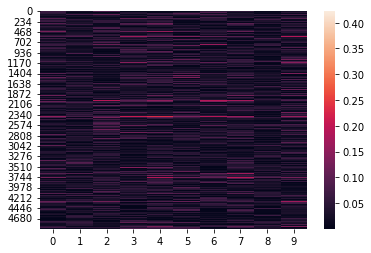

In [61]:
sns.heatmap(np.absolute(model.weights[0].numpy()))

In [62]:
data.index

Index(['AAMP', 'AAR2', 'AARS', 'AASDHPPT', 'AATF', 'ABAT', 'ABCA1', 'ABCA7',
       'ABCB7', 'ABCC10',
       ...
       'ZNHIT6', 'ZNRD2', 'ZPR1', 'ZRSR2', 'ZSCAN18', 'ZSCAN32', 'ZSWIM8',
       'ZXDC', 'ZYX', 'ZZEF1'],
      dtype='object', name='Unnamed: 0', length=4911)

In [164]:
# Identify genes that we've found as extremely important
lupus_probability = []

# For each gene, pretend that we only have this gene turned on, then calculate probability of having lupus.
genes = data.index
for pos, gene in enumerate(genes):
    input_val = np.zeros([1, len(genes)])
    input_val[0][pos] = 1
    probability = model.predict(input_val)[0][1]
    print(F"Gene {gene}: {probability}")
    lupus_probability.append([probability, gene])

Gene AAMP: 0.5890421271324158
Gene AAR2: 0.6098287105560303
Gene AARS: 0.5965854525566101
Gene AASDHPPT: 0.6017497181892395
Gene AATF: 0.5991302132606506
Gene ABAT: 0.58784419298172
Gene ABCA1: 0.680936336517334
Gene ABCA7: 0.6063008904457092
Gene ABCB7: 0.6132755279541016
Gene ABCC10: 0.6172207593917847
Gene ABCC5: 0.6037821769714355
Gene ABCD3: 0.5851083397865295
Gene ABCE1: 0.6136677265167236
Gene ABCF1: 0.5847473740577698
Gene ABCG1: 0.654608964920044
Gene ABHD10: 0.6005943417549133
Gene ABHD14A: 0.6191070079803467
Gene ABHD17A: 0.6288493871688843
Gene ABHD17B: 0.6040118336677551
Gene ABHD2: 0.6008985042572021
Gene ABHD3: 0.5815640091896057
Gene ABHD5: 0.6042822599411011
Gene ABI1: 0.6360037922859192
Gene ABITRAM: 0.6285063028335571
Gene ABLIM1: 0.5948275327682495
Gene ABR: 0.6316879987716675
Gene ABRAXAS2: 0.6305577158927917
Gene ABT1: 0.594894289970398
Gene ACAA1: 0.6288661360740662
Gene ACAA2: 0.6267872452735901
Gene ACACB: 0.5889347791671753
Gene ACADM: 0.5982320308685303
Gene 

In [165]:
lupus_probability = np.array(sorted(lupus_probability, key=lambda x: -x[0]))
lupus_probability[:50][:,1]

array(['XIST', 'USP18', 'ITM2A', 'HERC5', 'ISG15', 'MMP9', 'TYMS',
       'SIRPB1', 'TMEM204', 'MT1E', 'IFITM3', 'COX16', 'ANXA3', 'MX1',
       'RPL24', 'IFITM2', 'TUBB6', 'LRP3', 'SGK1', 'PSMA6', 'EIF1B',
       'RSAD2', 'ERGIC2', 'IFI16', 'HMGB2', 'F8A3', 'BIRC3', 'UFL1',
       'TRAK2', 'S100A8', 'VNN1', 'DDX60', 'ABCA1', 'LGALS3BP', 'ERH',
       'OAS3', 'SLC36A1', 'GASK1B', 'LGALS1', 'PTTG1', 'TRPS1', 'SP140',
       'GAPDH', 'FABP5', 'SRBD1', 'ARID5B', 'RAB13', 'ACAP1', 'EIF2AK2',
       'TMSB10'], dtype='<U32')

In [83]:
print("\n".join(lupus_probability[:50][:,1]))

USP18
XIST
ISG15
HERC5
ITM2A
MMP9
TIMM10
RSAD2
SGK1
SIRPB1
MX1
CPT1B
TYMS
FABP5
COX16
BLOC1S1
LRP3
IFITM3
LGALS3BP
RPL24
EIF2AK2
LXN
SRBD1
TMEM204
MT1F
OAS3
MT1E
EIF1B
ABCA1
DPM1
CMC2
SPATS2L
LGALS1
HMBOX1
COMMD3
NDUFA1
IFITM2
PSMA6
PRDX4
TMSB10
RRM2
PTTG1
SLPI
RPS20
STAT4
IFI16
VNN1
HCP5
TRAK2
ARG1
